create database to store data

In [20]:
import sqlite3
con = sqlite3.connect("swiss3d.db")
cur = con.cursor()

using the convention from [wiki](https://de.wikipedia.org/wiki/Schweizer_Landeskoordinaten)

In [23]:
#check if not already exist
res = cur.execute("SELECT name FROM sqlite_master")
if "dhm200" not in list(res.fetchone()):
    cur.execute("CREATE TABLE IF NOT EXIST dhm200(x, y, z)")
else:
    print("already exist")

already exist


## Read asc file

In [3]:
file = open('data/dhm/DHM200.asc', 'r')
lines = file.readlines()
n_head_lines = 6
header = lines[:n_head_lines]
data = [line.strip().split(" ") for line in lines[n_head_lines:]]
flat = []
for line in data:
    flat += line
flat = list(map(float, flat))
meta = {head.split(" ")[0].lower():float(head.split(" ")[1].strip()) for head in header}
for key, value in meta.items():
    if int(value)==value:
        meta[key] = int(value)
meta

{'ncols': 1926,
 'nrows': 1201,
 'xllcorner': 479900,
 'yllcorner': 61900,
 'cellsize': 200,
 'nodata_value': -9999}

evaluate data

In [4]:
if len(flat)/meta["nrows"]==meta["ncols"]:
    print("passed")
else:
    print("failed:", len(flat)/meta["nrows"],"not",meta["ncols"])

passed


In [5]:
chunks = [flat[x:x+meta["ncols"]] for x in range(0, len(flat), meta["ncols"])]

In [6]:
import numpy as np

In [7]:
x = np.ones(meta["ncols"]).cumsum()
x -= 1 
x *= meta["cellsize"]
x += meta["xllcorner"]
x

array([479900., 480100., 480300., ..., 864500., 864700., 864900.])

In [8]:
y = np.ones(meta["nrows"]).cumsum()
y -= 1
y *= meta["cellsize"]
y += meta["yllcorner"]
y = np.flip(y)
y

array([301900., 301700., 301500., ...,  62300.,  62100.,  61900.])

In [9]:
import pandas as pd

In [10]:
swiss = pd.DataFrame(chunks, columns=x, index=y)
swiss.replace(meta["nodata_value"], np.nan, inplace=True)
print("shape:",swiss.shape)
swiss

shape: (1201, 1926)


,479900.0,480100.0,480300.0,480500.0,480700.0,480900.0,481100.0,481300.0,481500.0,481700.0,...,863100.0,863300.0,863500.0,863700.0,863900.0,864100.0,864300.0,864500.0,864700.0,864900.0
301900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
print(f"y min\t: {swiss.index.min()}")
print(f"y max\t: {swiss.index.max()}")
print(f"x min\t: {swiss.columns.min()}")
print(f"x max\t: {swiss.columns.max()}")


y min	: 61900.0
y max	: 301900.0
x min	: 479900.0
x max	: 864900.0


create long format to save in database

In [13]:
swiss_ = swiss.reset_index(names="y").melt(id_vars="y", var_name="x", value_name="z").dropna(how="any")
swiss_["x"] = swiss_["x"].astype(float)
swiss_.describe()

,y,x,z
count,1.465616e+06,1.465616e+06,1.465616e+06
mean,1.872778e+05,6.646408e+05,1.277634e+03
std,5.444437e+04,9.175651e+04,8.063224e+02
min,7.390000e+04,4.799000e+05,1.930000e+02
25%,1.447000e+05,5.897000e+05,5.688000e+02
50%,1.847000e+05,6.655000e+05,1.026693e+03
75%,2.289000e+05,7.353000e+05,1.913188e+03
max,3.019000e+05,8.649000e+05,4.556625e+03


In [14]:
swiss_.dtypes

y    float64
x    float64
z    float64
dtype: object

In [15]:
swiss_ = swiss_.astype(int)
swiss_.dtypes

y    int64
x    int64
z    int64
dtype: object

## Insert data in database

In [16]:
swiss_.to_sql("dhm200", con, if_exists="replace", index=False)

1465616

commit insert

In [17]:
con.commit()

## check some database requests

In [24]:
res = cur.execute("SELECT DISTINCT(x) FROM dhm200")
res.fetchone()

(479900,)

In [25]:
swiss_ = pd.read_sql("SELECT x,y,z from dhm200 WHERE (x BETWEEN 500000 AND 600000) AND (y BETWEEN 100000 AND 200000)", con)
swiss_

,x,y,z
0,500100,181900,872
1,500100,181700,878
2,500100,181500,879
3,500100,181300,884
4,500100,181100,884
...,...,...,...
231134,599900,100900,3247
231135,599900,100700,3272
231136,599900,100500,3281
231137,599900,100300,3255


recreate 2d landscape

In [29]:
swiss = swiss_.pivot(index="y", columns="x", values="z")
swiss.sort_index(axis="index", ascending=False, inplace=True)
swiss.sort_index(axis="columns", ascending=True, inplace=True)
swiss

x,500100,500300,500500,500700,500900,501100,501300,501500,501700,501900,...,598100,598300,598500,598700,598900,599100,599300,599500,599700,599900
y,,,,,,,,,,,,,,,,,,,,,
199900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,556.0,552.0,552.0,550.0,546.0,548.0,561.0,564.0,560.0,560.0
199700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,554.0,557.0,557.0,557.0,549.0,549.0,554.0,545.0,553.0,549.0
199500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,546.0,552.0,549.0,560.0,545.0,539.0,538.0,533.0,541.0,544.0
199300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,539.0,541.0,547.0,547.0,536.0,529.0,528.0,529.0,535.0,537.0
199100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,541.0,539.0,539.0,550.0,529.0,527.0,526.0,527.0,526.0,530.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3045.0,3089.0,3043.0,3107.0,3097.0,3113.0,3186.0,3333.0,3288.0,3247.0
100700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2983.0,2970.0,3003.0,3075.0,3105.0,3150.0,3211.0,3430.0,3318.0,3272.0
100500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2879.0,2915.0,2946.0,3001.0,3103.0,3117.0,3240.0,3562.0,3333.0,3281.0


## Create Surface

In [30]:
df = swiss

In [31]:
x = np.ones(df.shape)
y = x.copy()

In [32]:
x *= np.array(df.columns)
x

array([[500100., 500300., 500500., ..., 599500., 599700., 599900.],
       [500100., 500300., 500500., ..., 599500., 599700., 599900.],
       [500100., 500300., 500500., ..., 599500., 599700., 599900.],
       ...,
       [500100., 500300., 500500., ..., 599500., 599700., 599900.],
       [500100., 500300., 500500., ..., 599500., 599700., 599900.],
       [500100., 500300., 500500., ..., 599500., 599700., 599900.]])

In [33]:
y = (y.T*np.array(df.index)).T
y

array([[199900., 199900., 199900., ..., 199900., 199900., 199900.],
       [199700., 199700., 199700., ..., 199700., 199700., 199700.],
       [199500., 199500., 199500., ..., 199500., 199500., 199500.],
       ...,
       [100500., 100500., 100500., ..., 100500., 100500., 100500.],
       [100300., 100300., 100300., ..., 100300., 100300., 100300.],
       [100100., 100100., 100100., ..., 100100., 100100., 100100.]])

In [34]:
z = np.array(df)
z

array([[  nan,   nan,   nan, ...,  564.,  560.,  560.],
       [  nan,   nan,   nan, ...,  545.,  553.,  549.],
       [  nan,   nan,   nan, ...,  533.,  541.,  544.],
       ...,
       [  nan,   nan,   nan, ..., 3562., 3333., 3281.],
       [  nan,   nan,   nan, ..., 3604., 3400., 3255.],
       [  nan,   nan,   nan, ..., 3493., 3306., 3248.]])

In [36]:
import pyvista as pv

In [37]:
mesh = pv.StructuredGrid(x, y, z)
#mesh.save(filename="src/cache/area_of_interest.vtk", binary=True)

In [38]:
mesh

StructuredGrid,Information
N Cells,249001
N Points,250000
X Bounds,"5.001e+05, 5.999e+05"
Y Bounds,"1.001e+05, 1.999e+05"
Z Bounds,"3.720e+02, 3.604e+03"
Dimensions,"500, 500, 1"
N Arrays,0


a:\GitHub\swiss3d\.venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


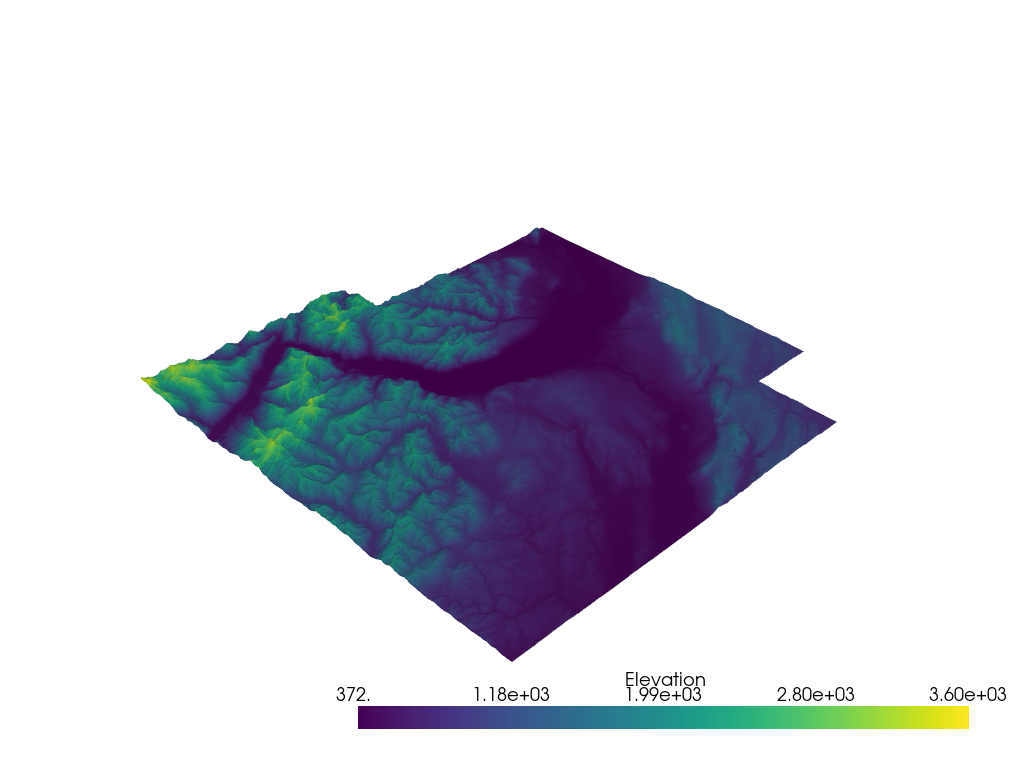

In [39]:
pl = pv.Plotter()
pl.add_mesh(mesh.elevation())
pl.show()